<a href="https://colab.research.google.com/github/james-sheridan-code/SOLUSD/blob/main/1_SOLUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy matplotlib xgboost hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Use 'SOL-USD' for Solana
df = yf.download('SOL-USD', start='2023-01-01', interval='1d')
df.columns = df.columns.get_level_values(0) # Clean multi-index if needed

/tmp/ipython-input-2089307401.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('SOL-USD', start='2023-01-01', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [ ]:
#clac log returns
df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))

In [ ]:
# 20-day rolling standard deviation of returns
df['volatility'] = df['log_ret'].rolling(window=20).std()

In [ ]:
df['ma_50'] = df['Close'].rolling(50).mean()
df['ma_200'] = df['Close'].rolling(200).mean()
df['trend_spread'] = (df['ma_50'] - df['ma_200']) / df['ma_200']

In [ ]:
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

In [ ]:
df.dropna(inplace=True)

In [ ]:
from hmmlearn.hmm import GaussianHMM

# We use Volatility and Returns to find the "Hidden" state
hmm_model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
features_hmm = df[['log_ret', 'volatility']].values
hmm_model.fit(features_hmm)
df['regime'] = hmm_model.predict(features_hmm)

In [ ]:
# 1 if price goes UP tomorrow, 0 if it goes DOWN
df['target'] = (df['log_ret'].shift(-1) > 0).astype(int)
df.dropna(inplace=True) # Remove the last row which has no 'tomorrow'

In [ ]:
split = int(len(df) * 0.8)
train_df = df.iloc[:split]
test_df = df.iloc[split:]

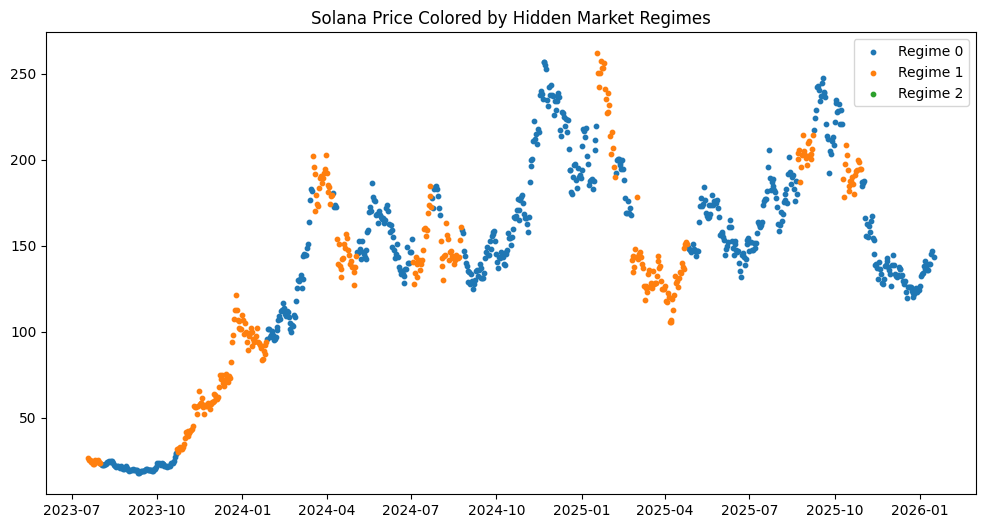

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for i in range(3):
    mask = df['regime'] == i
    plt.scatter(df.index[mask], df['Close'].loc[mask], label=f'Regime {i}', s=10)
plt.title("Solana Price Colored by Hidden Market Regimes")
plt.legend()
plt.show()

In [ ]:
print(df[['Close', 'volatility', 'regime', 'target']].head())

Price           Close  volatility  regime  target
Date                                             
2023-07-19  26.372353    0.046939       0       0
2023-07-20  25.375168    0.048031       0       1
2023-07-21  25.544268    0.047684       0       0
2023-07-22  24.535053    0.048879       0       1
2023-07-23  24.766815    0.048594       0       0


In [ ]:
# DATA CHECKS

print(df.head()) #first 5 rows to sample the data
print(df.describe()) #descriptive stats of the data
print(df.info()) #count and type per column in the data

Price           Close       High        Low       Open     Volume   log_ret  \
Date                                                                          
2023-07-19  26.372353  26.922089  25.418062  25.550882  603189951  0.031894   
2023-07-20  25.375168  26.896439  25.169426  26.368727  606255421 -0.038545   
2023-07-21  25.544268  25.947922  25.142338  25.375525  410907584  0.006642   
2023-07-22  24.535053  25.950357  24.306475  25.543179  335432006 -0.040310   
2023-07-23  24.766815  25.213612  24.250967  24.532663  330741258  0.009402   

Price       volatility      ma_50     ma_200  trend_spread        rsi  regime  \
Date                                                                            
2023-07-19    0.046939  19.456039  20.830879     -0.066000  79.768391       1   
2023-07-20    0.048031  19.547052  20.907844     -0.065085  72.305644       1   
2023-07-21    0.047684  19.647893  20.979201     -0.063458  68.337178       1   
2023-07-22    0.048879  19.713442  21.035

In [ ]:
#PHASE 2

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the features we want the model to learn from
features = ['log_ret', 'volatility', 'trend_spread', 'rsi', 'regime']

X_train = train_df[features]
y_train = train_df['target']

X_test = test_df[features]
y_test = test_df['target']

In [ ]:
# Initialize the "Detective" (XGBoost)
model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

Model Accuracy: 55.19%


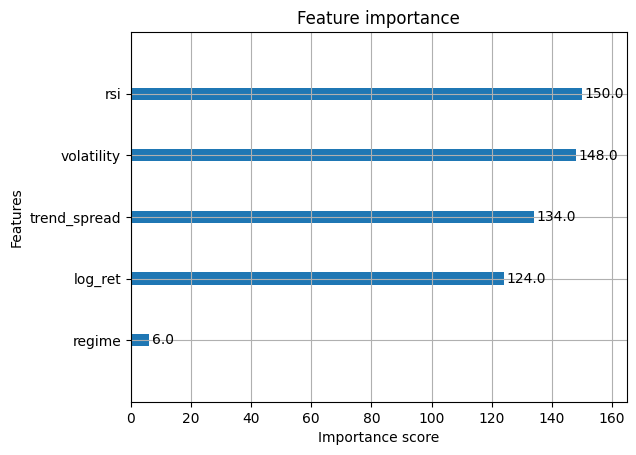

In [ ]:
# Predict the direction for the test set
y_pred = model.predict(X_test)

# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# See which features were most important
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()

/tmp/ipython-input-1050617124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = model.predict(X_test)
/tmp/ipython-input-1050617124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['strategy_returns'] = test_df['prediction'] * test_df['log_ret'].shift(-1)
/tmp/ipython-input-1050617124.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

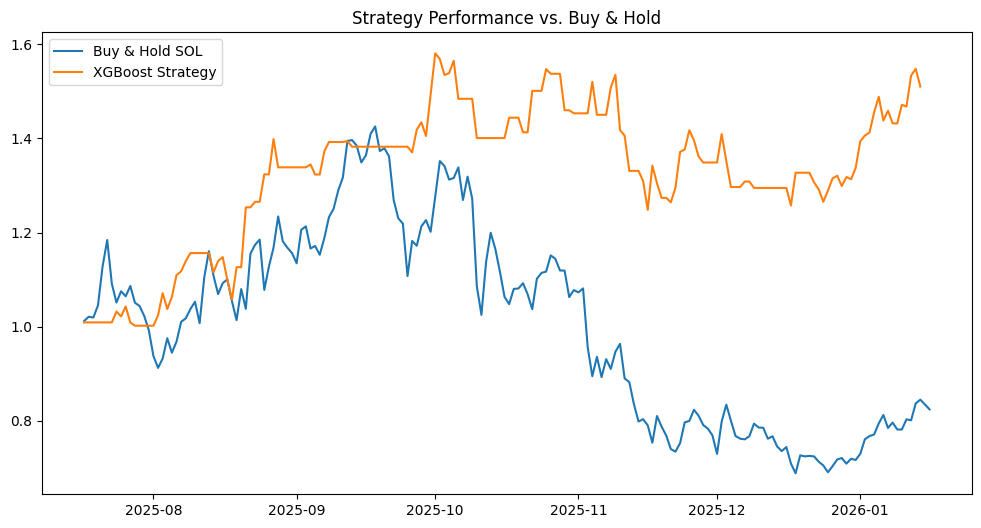

In [ ]:
# Calculate Strategy Returns
# 1. Get the model's probability of an "Up" move
test_df['prediction'] = model.predict(X_test)

# 2. If prediction is 1, we get the 'next day' return. If 0, we get 0.
test_df['strategy_returns'] = test_df['prediction'] * test_df['log_ret'].shift(-1)

# 3. Calculate Cumulative Returns
test_df['cum_market_returns'] = test_df['log_ret'].cumsum().apply(np.exp)
test_df['cum_strategy_returns'] = test_df['strategy_returns'].cumsum().apply(np.exp)

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(test_df['cum_market_returns'], label='Buy & Hold SOL')
plt.plot(test_df['cum_strategy_returns'], label='XGBoost Strategy')
plt.title("Strategy Performance vs. Buy & Hold")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Print the simple accuracy again
print(f"--- Global Accuracy: {accuracy:.2%} ---")
print("\n")

# 2. Print the Classification Report
# This shows Precision (when it says UP, how often is it right?)
# and Recall (out of all actual UP days, how many did it catch?)
print("Detailed Statistics:")
print(classification_report(y_test, y_pred, target_names=['Price Down', 'Price Up']))

# 3. Print the Confusion Matrix
# [True Negatives, False Positives]
# [False Negatives, True Positives]
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

--- Global Accuracy: 55.19% ---


Detailed Statistics:
              precision    recall  f1-score   support

  Price Down       0.57      0.49      0.53        94
    Price Up       0.53      0.62      0.57        89

    accuracy                           0.55       183
   macro avg       0.55      0.55      0.55       183
weighted avg       0.56      0.55      0.55       183

Confusion Matrix:
[[46 48]
 [34 55]]


In [ ]:
# Calculate Strategy Metrics
strategy_rets = test_df['strategy_returns'].dropna()

# 1. Annualized Sharpe Ratio (Risk-free rate assumed 0 for simplicity)
# S = (Mean Return / Std Dev) * sqrt(Trading Days)
sharpe = (strategy_rets.mean() / strategy_rets.std()) * np.sqrt(252)

# 2. Maximum Drawdown (The Peak-to-Trough pain)
cum_rets = test_df['cum_strategy_returns']
peak = cum_rets.cummax()
drawdown = (cum_rets - peak) / peak
max_drawdown = drawdown.min()

print(f"--- Strategy Scorecard ---")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Total Return: {(cum_rets.iloc[-1] - 1):.2%}")

--- Strategy Scorecard ---
Sharpe Ratio: 1.44
Max Drawdown: -21.05%
Total Return: nan%


/tmp/ipython-input-3969101489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['trades'] = test_df['prediction'].diff().fillna(0).abs()
/tmp/ipython-input-3969101489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['strategy_net_returns'] = test_df['strategy_returns'] - (test_df['trades'] * 0.001)
/tmp/ipython-input-3969101489.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

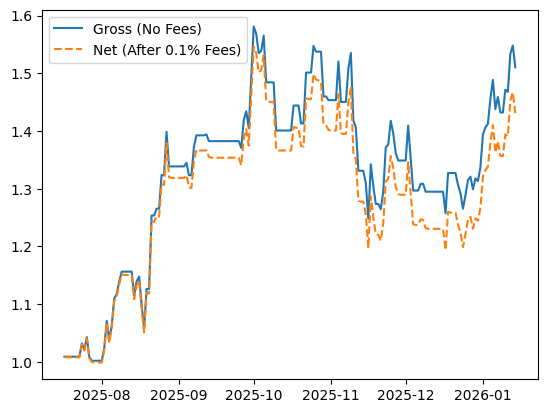

In [ ]:
# Assume a 0.1% fee per trade (Standard for 2026 exchanges)
test_df['trades'] = test_df['prediction'].diff().fillna(0).abs()
test_df['strategy_net_returns'] = test_df['strategy_returns'] - (test_df['trades'] * 0.001)
test_df['cum_net_strategy'] = test_df['strategy_net_returns'].cumsum().apply(np.exp)

# Compare Net vs Gross
plt.plot(test_df['cum_strategy_returns'], label='Gross (No Fees)')
plt.plot(test_df['cum_net_strategy'], label='Net (After 0.1% Fees)', linestyle='--')
plt.legend()
plt.show()

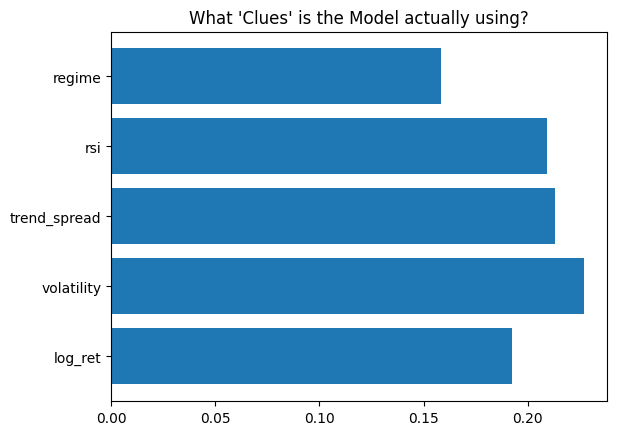

In [ ]:
importances = model.feature_importances_
feature_names = features
plt.barh(feature_names, importances)
plt.title("What 'Clues' is the Model actually using?")
plt.show()